In [1]:
# Importing the necessary libraries for Model build and Evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Loading the cleaned 15lakh sample Dataset
Train = pd.read_csv("Training Data.csv")

In [3]:
# Checking Unique count of the columns
for col in Train:
    print(col,'\t',Train[col].nunique())


Id 	 394898
OrgId 	 4824
IncidentId 	 292792
AlertId 	 702673
DetectorId 	 6306
AlertTitle 	 56681
Category 	 19
IncidentGrade 	 3
EntityType 	 29
EvidenceRole 	 2
DeviceId 	 27431
Sha256 	 33823
IpAddress 	 95082
Url 	 37555
AccountSid 	 142120
AccountUpn 	 214601
AccountObjectId 	 139572
AccountName 	 146096
DeviceName 	 40008
NetworkMessageId 	 119344
RegistryKey 	 477
RegistryValueName 	 178
RegistryValueData 	 256
ApplicationId 	 459
ApplicationName 	 717
OAuthApplicationId 	 164
FileName 	 59840
FolderPath 	 27947
ResourceIdName 	 605
OSFamily 	 5
OSVersion 	 36
CountryCode 	 184
State 	 902
City 	 3939


**Checking for High-Cardinality and reducing its size**

In [4]:
def reduce_high_cardinality_columns(df,columns):
    for col in columns:
        frequent_values = df[col].value_counts().index[:3]
        df[col] = df[col].apply(lambda x: x if x in frequent_values else "Others")
    return df

df = Train

columns_to_reduce = [ "OrgId", "IncidentId", "AlertId", "DetectorId", "AlertTitle", "DeviceId", "Sha256", "IpAddress", "Url", "AccountSid",
                      "AccountUpn", "AccountObjectId", "AccountName", "DeviceName", "NetworkMessageId", "RegistryKey", "RegistryValueName",
                      "RegistryValueData", "ApplicationId", "ApplicationName", "OAuthApplicationId", "FileName", "FolderPath", "ResourceIdName",
                      "OSVersion", "CountryCode", "State", "City", "Category", "EntityType" ]


Train = reduce_high_cardinality_columns(df,columns_to_reduce)
Train

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,893353197938,Others,Others,Others,Others,Others,InitialAccess,BenignPositive,MailMessage,Related,...,3421,881,289573,117668,3586,5,66,242,1445,10630
1,987842478693,Others,Others,Others,1,1,InitialAccess,BenignPositive,MailMessage,Related,...,3421,881,289573,117668,3586,5,66,242,1445,10630
2,936302874005,2,Others,Others,Others,Others,Exfiltration,BenignPositive,MailMessage,Impacted,...,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1486058689361,Others,Others,Others,Others,Others,Exfiltration,FalsePositive,MailMessage,Impacted,...,3421,881,289573,117668,3586,5,66,242,1445,10630
4,128849019531,Others,Others,Others,Others,Others,InitialAccess,TruePositive,User,Impacted,...,3421,881,289573,117668,3586,5,66,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499995,996432415824,Others,Others,Others,2,2,Others,BenignPositive,User,Impacted,...,3421,881,289573,117668,3586,5,66,242,1445,10630
1499996,1494648619207,Others,Others,Others,0,0,InitialAccess,FalsePositive,User,Impacted,...,3421,881,289573,117668,3586,5,66,242,1445,10630
1499997,1683627181326,Others,Others,Others,0,0,InitialAccess,FalsePositive,Others,Related,...,3421,881,289573,117668,3586,5,66,242,1445,10630
1499998,1657857378048,0,Others,Others,0,0,InitialAccess,TruePositive,Others,Related,...,3421,881,289573,117668,3586,5,66,242,1445,10630


In [5]:
for col in Train:
    print(col,'\t',Train[col].nunique())

Id 	 394898
OrgId 	 4
IncidentId 	 4
AlertId 	 4
DetectorId 	 4
AlertTitle 	 4
Category 	 4
IncidentGrade 	 3
EntityType 	 4
EvidenceRole 	 2
DeviceId 	 4
Sha256 	 4
IpAddress 	 4
Url 	 4
AccountSid 	 4
AccountUpn 	 4
AccountObjectId 	 4
AccountName 	 4
DeviceName 	 4
NetworkMessageId 	 4
RegistryKey 	 4
RegistryValueName 	 4
RegistryValueData 	 4
ApplicationId 	 4
ApplicationName 	 4
OAuthApplicationId 	 4
FileName 	 4
FolderPath 	 4
ResourceIdName 	 4
OSFamily 	 5
OSVersion 	 4
CountryCode 	 4
State 	 4
City 	 4


**Applying the Label Encoding for the categoric columns and the numeric column that is been treated as categoric**

In [6]:
Categoric_columns = ['OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
                     'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName',
                     'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
                     'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode','State', 'City']

# Apply Label Encoding
encoders = {}
for col in Categoric_columns:
    le = LabelEncoder()
    Train[col] = le.fit_transform(Train[col].astype(str))
    encoders[col] = le  # Save the encoder for this column
Train

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,893353197938,3,3,3,3,3,1,0,1,1,...,2,2,2,2,2,4,2,2,2,2
1,987842478693,3,3,3,1,1,1,0,1,1,...,2,2,2,2,2,4,2,2,2,2
2,936302874005,2,3,3,3,3,0,0,1,0,...,2,2,2,2,2,4,2,2,2,2
3,1486058689361,3,3,3,3,3,0,1,1,0,...,2,2,2,2,2,4,2,2,2,2
4,128849019531,3,3,3,3,3,1,2,3,0,...,2,2,2,2,2,4,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499995,996432415824,3,3,3,2,2,2,0,3,0,...,2,2,2,2,2,4,2,2,2,2
1499996,1494648619207,3,3,3,0,0,1,1,3,0,...,2,2,2,2,2,4,2,2,2,2
1499997,1683627181326,3,3,3,0,0,1,1,2,1,...,2,2,2,2,2,4,2,2,2,2
1499998,1657857378048,0,3,3,0,0,1,2,2,1,...,2,2,2,2,2,4,2,2,2,2


**Apply SMOTE to handle the imbalanced data of the Target column "IncidentGrade"**

In [7]:
# Define features and target variable
X = Train.drop(columns=['IncidentGrade'])    # Drop the target variable column from features
y = Train['IncidentGrade']                   # Target variable

""" Train-Test Split (Before SMOTE) """
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

""" Apply SMOTE Only on the Train Set """
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [8]:
# Check the shape of the balanced dataset
print("Balanced Training Set Shape:", X_train_balanced.shape, y_train_balanced.shape)

# Class distribution before SMOTE
print("\nClass Distribution Before SMOTE:")
print(y_train.value_counts())

# Class distribution after SMOTE
print("\nClass Distribution After SMOTE:")
print(y_train_balanced.value_counts())

""" Display Train-Test Split Sizes """
print("\nFinal Dataset Sizes After SMOTE:")
print("Training set size:", X_train_balanced.shape)
print("Validation set size:", X_val.shape)
print("Training target size:", y_train_balanced.shape)
print("Validation target size:", y_val.shape)

Balanced Training Set Shape: (1574067, 33) (1574067,)

Class Distribution Before SMOTE:
IncidentGrade
0    524689
2    419524
1    255787
Name: count, dtype: int64

Class Distribution After SMOTE:
IncidentGrade
2    524689
1    524689
0    524689
Name: count, dtype: int64

Final Dataset Sizes After SMOTE:
Training set size: (1574067, 33)
Validation set size: (300000, 33)
Training target size: (1574067,)
Validation target size: (300000,)


**Model Selection and Training**

**1. Decision Tree**

Macro F1 Score (Decision Tree): 0.511186387934159
Precision (Decision Tree): 0.6418832268125488
Recall (Decision Tree): 0.518135208392678

 Decision Tree Performance on Validation Set:
              precision    recall  f1-score   support

          TP       0.57      0.90      0.70    131172
          BP       0.36      0.33      0.34     63947
          FP       1.00      0.33      0.49    104881

    accuracy                           0.58    300000
   macro avg       0.64      0.52      0.51    300000
weighted avg       0.67      0.58      0.55    300000
 

Cross-validation F1 scores: [0.49805143 0.49884584 0.5469787  0.58513387 0.57044473]
Mean cross-validation F1 score: 0.5398909138308803


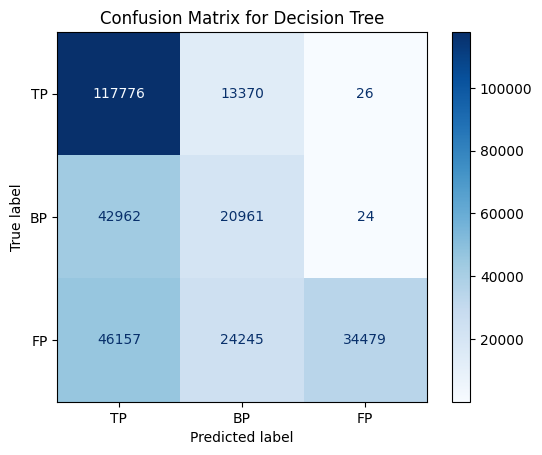

In [9]:
# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
tree_model.fit(X_train_balanced, y_train_balanced)

# Predictions on validation set
y_val_pred_tree = tree_model.predict(X_val)


# Calculate F1-Score, Precision, Recall for Decision Tree
tree_f1 = f1_score(y_val, y_val_pred_tree, average='macro')                  # Provides the balance between precision and recall
tree_precision = precision_score(y_val, y_val_pred_tree, average='macro')    # Knowing the predicted positive cases
tree_recall = recall_score(y_val, y_val_pred_tree, average='macro')          # Knowing the actual positive cases

print(f"Macro F1 Score (Decision Tree): {tree_f1}")
print(f"Precision (Decision Tree): {tree_precision}")
print(f"Recall (Decision Tree): {tree_recall}")

# Evaluate Decision Tree
print("\n Decision Tree Performance on Validation Set:")
print(classification_report(y_val, y_val_pred_tree, target_names=['TP', 'BP', 'FP']),'\n')

# cross-validation
cv_scores = cross_val_score(tree_model, X_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean cross-validation F1 score: {cv_scores.mean()}")

# Decision Tree Confusion Matrix
cm_tree = confusion_matrix(y_val, y_val_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['TP', 'BP', 'FP'])
disp_tree.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree")
plt.show()

**2. Logistic Regression**

Macro F1 Score (Logistic Regression): 0.20281465401278376
Precision (Logistic Regression): 0.14574666666666666
Recall (Logistic Regression): 0.3333333333333333

Logistic Regression Performance on Validation Set:
              precision    recall  f1-score   support

          TP       0.44      1.00      0.61    131172
          BP       0.00      0.00      0.00     63947
          FP       0.00      0.00      0.00    104881

    accuracy                           0.44    300000
   macro avg       0.15      0.33      0.20    300000
weighted avg       0.19      0.44      0.27    300000
 

Cross-validation F1 scores: [0.16666667 0.16666667 0.16666587 0.16666706 0.16666706]
Mean cross-validation F1 score: 0.16666666666628832


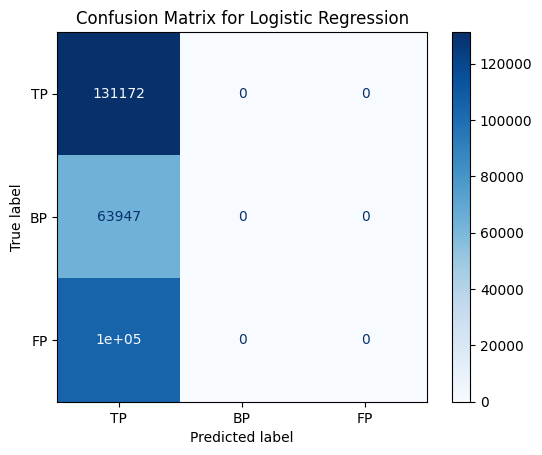

In [10]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logistic_model.fit(X_train_balanced, y_train_balanced)

# Predictions on validation set
y_val_pred_logistic = logistic_model.predict(X_val)

# Calculate F1-Score, Precision, Recall for Logistic Regression
logistic_f1 = f1_score(y_val, y_val_pred_logistic, average='macro',  zero_division=0)               # Provides the balance between precision and recall
logistic_precision = precision_score(y_val, y_val_pred_logistic, average='macro', zero_division=0)  # Knowing the predicted positive cases
logistic_recall = recall_score(y_val, y_val_pred_logistic, average='macro', zero_division=0)        # Knowing the actual positive cases


print(f"Macro F1 Score (Logistic Regression): {logistic_f1}")
print(f"Precision (Logistic Regression): {logistic_precision}")
print(f"Recall (Logistic Regression): {logistic_recall}")

# Evaluate Logistic Regression
print("\nLogistic Regression Performance on Validation Set:")
print(classification_report(y_val, y_val_pred_logistic, target_names=['TP', 'BP', 'FP'], zero_division=0),'\n')

# cross-validation
cv_scores = cross_val_score(logistic_model, X_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean cross-validation F1 score: {cv_scores.mean()}")

# Logistic Regression Confusion Matrix
cm_logistic = confusion_matrix(y_val, y_val_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=['TP', 'BP', 'FP'])
disp_logistic.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

**3. Random Forest**

Random Forest Performance on Validation Set:
Macro F1 Score: 0.6837379759426239
Precision: 0.7083940931516
Recall: 0.6731502247314326

Random Forest Performance on Validation Set (Detailed):
              precision    recall  f1-score   support

          TP       0.68      0.84      0.75    131172
          BP       0.65      0.51      0.57     63947
          FP       0.79      0.67      0.73    104881

    accuracy                           0.71    300000
   macro avg       0.71      0.67      0.68    300000
weighted avg       0.71      0.71      0.70    300000
 

Cross-validation F1 scores: [0.65953338 0.65961882 0.74064558 0.77791281 0.70819581]
Mean cross-validation F1 score: 0.7091812801752811


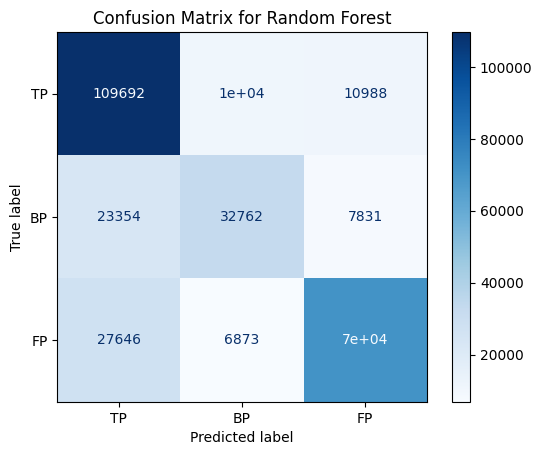

In [11]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predictions on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate Random Forest
rf_f1 = f1_score(y_val, y_val_pred_rf, average='macro')                             # Provides the balance between precision and recall
rf_precision = precision_score(y_val, y_val_pred_rf, average='macro')               # Knowing the predicted positive cases
rf_recall = recall_score(y_val, y_val_pred_rf, average='macro')                     # Knowing the actual positive cases


# Print the evaluation metrics
print("Random Forest Performance on Validation Set:")
print(f"Macro F1 Score: {rf_f1}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")

# Detailed classification report
print("\nRandom Forest Performance on Validation Set (Detailed):")
print(classification_report(y_val, y_val_pred_rf, target_names=['TP', 'BP', 'FP']),'\n')

# cross-validation
cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean cross-validation F1 score: {cv_scores.mean()}")

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['TP', 'BP', 'FP'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest")
plt.show()

**4. XGBoost**

XGBoost Performance on Validation Set:
Macro F1 Score: 0.6385844947703828
Precision: 0.690157195484273
Recall: 0.6261496592394046

XGBoost Performance on Validation Set (Detailed):
              precision    recall  f1-score   support

          TP       0.63      0.87      0.73    131172
          BP       0.64      0.40      0.49     63947
          FP       0.80      0.61      0.69    104881

    accuracy                           0.68    300000
   macro avg       0.69      0.63      0.64    300000
weighted avg       0.69      0.68      0.67    300000
 



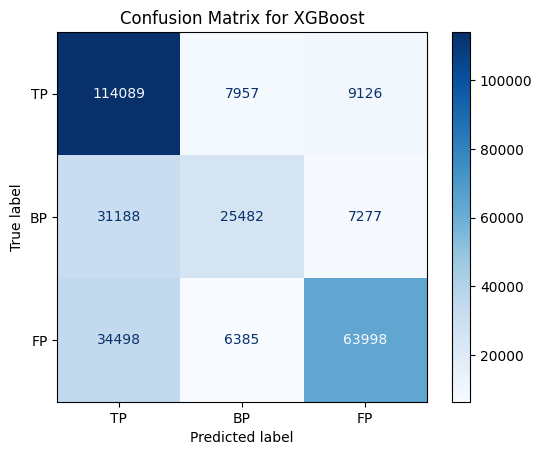

In [12]:
# XGBoost - Extreme Gradient Boosting
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predictions on validation set
y_val_pred_xgb = xgb_model.predict(X_val)

# Evaluate XGBoost
xgb_precision = precision_score(y_val, y_val_pred_xgb, average='macro')                     # Provides the balance between precision and recall
xgb_recall = recall_score(y_val, y_val_pred_xgb, average='macro')                           # Knowing the predicted positive cases
xgb_f1 = f1_score(y_val, y_val_pred_xgb, average='macro')                                   # Knowing the actual positive cases


print("XGBoost Performance on Validation Set:")
print(f"Macro F1 Score: {xgb_f1}")
print(f"Precision: {xgb_precision}")
print(f"Recall: {xgb_recall}")

# Detailed classification report
print("\nXGBoost Performance on Validation Set (Detailed):")
print(classification_report(y_val, y_val_pred_xgb, target_names=['TP', 'BP', 'FP']),'\n')

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['TP', 'BP', 'FP'])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost")
plt.show()



**By Training the 4 different models, I chose the Random Forest Model because it was more accurate, achieved a higher F1-score, and demonstrated balanced precision and recall, making it the most reliable choice.**

**Using Hyperparameter Tuning for the Random forest model to optimize its performance by finding the best combination of parameters, ensuring improved accuracy and generalization on unseen data.**

In [13]:
# Define a smaller hyperparameter grid for faster tuning
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [10, 30, None],       # Tree depth
    'min_samples_split': [2, 5],       # Minimum samples to split
    'min_samples_leaf': [1, 2],        # Minimum samples per leaf
    'bootstrap': [True]                # Bootstrap sampling
}

# Initialize Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Use Randomized Search for tuning (faster than GridSearchCV)
rf_random = RandomizedSearchCV(
    estimator=rf_model, param_distributions=param_grid, 
    n_iter=5, cv=3, scoring='f1_macro', 
    verbose=1, n_jobs=-1, random_state=42
)

# Train on balanced dataset
rf_random.fit(X_train_balanced, y_train_balanced)

# Print the best parameters
print("Best Hyperparameters for Random Forest:", rf_random.best_params_)

# Train the final model with best parameters
best_rf = rf_random.best_estimator_
y_val_pred_rf = best_rf.predict(X_val)

# Evaluate the tuned model
print("\nRandom Forest Performance After Tuning:")
print(classification_report(y_val, y_val_pred_rf, target_names=['TP', 'BP', 'FP']))

# Calculate Metrics
rf_f1 = f1_score(y_val, y_val_pred_rf, average='macro')
rf_precision = precision_score(y_val, y_val_pred_rf, average='macro')
rf_recall = recall_score(y_val, y_val_pred_rf, average='macro')

print("\nRandom Forest Performance After Tuning Score:\n")
print(f"Macro F1 Score: {rf_f1}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}

Random Forest Performance After Tuning:
              precision    recall  f1-score   support

          TP       0.67      0.86      0.75    131172
          BP       0.68      0.48      0.56     63947
          FP       0.79      0.65      0.71    104881

    accuracy                           0.70    300000
   macro avg       0.71      0.66      0.67    300000
weighted avg       0.71      0.70      0.70    300000


Random Forest Performance After Tuning Score:

Macro F1 Score: 0.6747752573216372
Precision: 0.7134428462549649
Recall: 0.6616855146111772


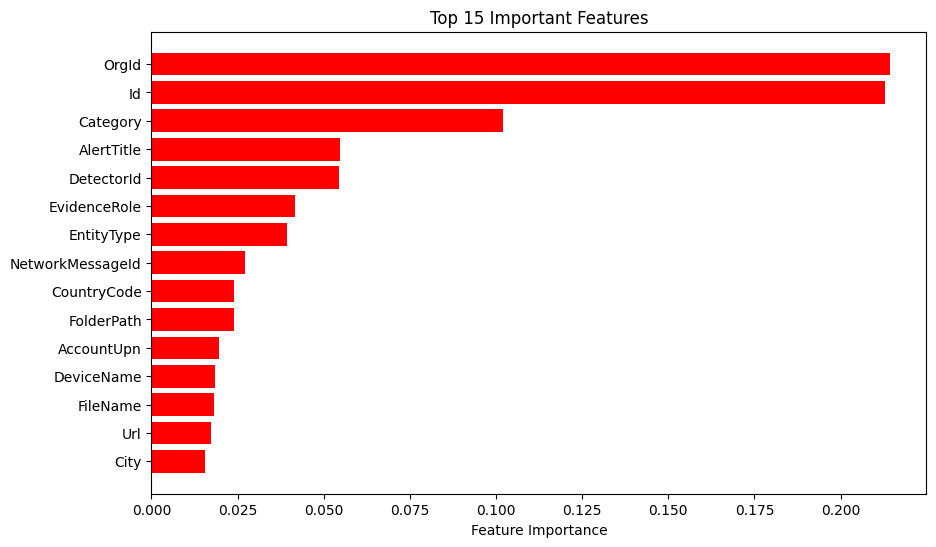

In [14]:
# Extract feature importance
feature_importances = best_rf.feature_importances_
feature_names = X_train_balanced.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15], color='red')
plt.gca().invert_yaxis()  # Reverse the order for better visualization
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features')
plt.show()

**For the final evaluation on the Test Dataset, I created a pipeline for data preprocessing, encoding, and sampling. I then imported the pipeline here, passed my dataset through it, and obtained the processed data for evaluating my Random Forest model**

In [15]:
# Load the test data
Testing = pd.read_csv("GUIDE_Test.csv", low_memory=False)

In [16]:
from Testing import Testing_Data

In [17]:
# Getting the pipeline
pipeline = Testing_Data()

In [18]:
# Preprocess the test data using the pipeline
Test = pipeline.fit_transform(Testing)


In [19]:
Test

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
2480092,1228360649769,3,3,3,1,1,1,0,2,0,...,2,2,2,2,1,4,2,2,2,2
437473,1571958032592,3,3,3,3,3,2,2,3,0,...,2,2,2,2,1,4,2,2,2,2
3166255,489626274159,3,3,3,1,1,1,0,2,1,...,2,2,2,2,1,4,2,2,2,2
2264349,386547060185,3,3,3,0,0,1,2,0,1,...,2,2,2,2,1,4,2,1,0,0
808028,429496732242,3,3,3,2,2,2,0,2,0,...,2,2,2,2,1,0,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677657,377957126944,2,3,3,3,3,1,1,2,0,...,2,2,2,2,1,4,2,2,2,2
3198825,1176821041132,3,3,3,3,3,2,0,2,0,...,2,2,2,2,1,0,0,2,2,2
1496591,1417339209710,3,3,3,0,0,1,2,0,1,...,2,2,2,2,1,4,2,3,3,3
1581260,927712940264,3,3,3,3,3,3,2,2,1,...,2,2,2,2,1,4,2,2,2,2


**Evaluating the Random Forest Model**

In [20]:
# Define features and target variable
X_Test = Test.drop(columns=['IncidentGrade'])    # Drop the target variable column from features
y_Test = Test['IncidentGrade']                   # Target variable

In [21]:
y_pred = best_rf.predict(X_Test)

print("Classification Report on Test Set:")
print(classification_report(y_Test, y_pred, target_names=['TP', 'BP', 'FP']))

# Calculate individual metrics
precision = precision_score(y_Test, y_pred, average='macro')  
recall = recall_score(y_Test, y_pred, average='macro')        
f1 = f1_score(y_Test, y_pred, average='macro')                

# Print the precision, recall, and F1-score
print(f"Macro Precision: {precision:.5f}")
print(f"Macro Recall: {recall:.5f}")
print(f"Macro F1-Score: {f1:.5f}")


Classification Report on Test Set:
              precision    recall  f1-score   support

          TP       0.58      0.83      0.68    633694
          BP       0.40      0.24      0.30    326031
          FP       0.73      0.53      0.61    540275

    accuracy                           0.59   1500000
   macro avg       0.57      0.53      0.53   1500000
weighted avg       0.59      0.59      0.57   1500000

Macro Precision: 0.56845
Macro Recall: 0.53283
Macro F1-Score: 0.53118


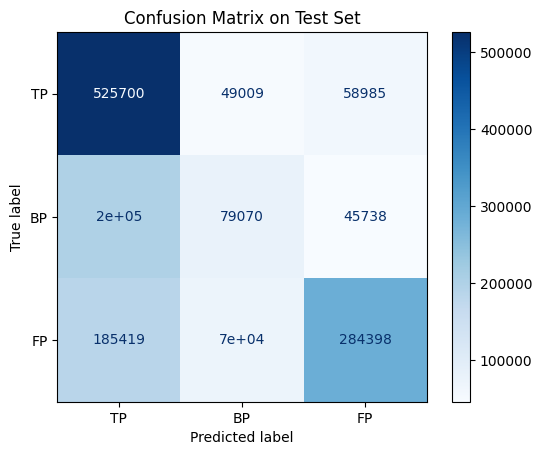

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_Test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['TP', 'BP', 'FP'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()